In [701]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve, auc
import itertools
from itertools import cycle
from sklearn import metrics
from scipy import interp
import os
import shutil
from keras import backend as K
import random
import glob
import matplotlib.pyplot as plt
import warnings
from keras.optimizers import rmsprop_v2

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [702]:
img_width, img_height = 150, 150

train_data_dir = 'cytology_xmass_07_01_22_1/train'
#validation_data_dir = '../input/main-dataset/main_dataset/validation'
test_data_dir = 'cytology_xmass_07_01_22_1/test'
nb_train_samples = 86
nb_validation_samples = 32
epochs = 50
batch_size = 8
#regularizer = tf.keras.regularizers.l2(0.01,)

#if K.image_data_format() == 'channels_first':
#  input_shape = (3, img_width, img_height)
#else:
input_shape = (img_width, img_height, 3)

In [703]:
train_datagen = ImageDataGenerator(
    #rescale = 1./255,
    #shear_range = 0.3,
    #zoom_range = 0.2,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #horizontal_flip = True
)

test_datagen = ImageDataGenerator(#rescale = 1./255
)

In [704]:
train_batches = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    #classes=['EOISINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'],
    class_mode = 'categorical')

Found 86 images belonging to 4 classes.


In [705]:
test_batches = test_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_width, img_height),
    batch_size = 32,
    #color_mode = 'grayscale',
    class_mode = 'categorical')

Found 32 images belonging to 4 classes.


In [706]:
def plots(ims, figsize=(12,6), rows=None, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows +1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [707]:
imgs, labels = next(train_batches)

In [711]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(4,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

model.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_163 (Conv2D)         (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_145 (MaxPooli  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_164 (Conv2D)         (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_146 (MaxPooli  (None, 36, 36, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_165 (Conv2D)         (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_147 (MaxPooli  (None, 17, 17, 128)    

In [712]:
%%time
h = model.fit_generator(
    train_batches,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = test_batches,
    validation_steps = nb_validation_samples // batch_size,
    #callbacks=[
    #    tf.keras.callbacks.ModelCheckpoint(filepath = '/kaggle/working/model_{val_accuracy:.3f}.h5', save_best_only=True,
    #                                      save_weights_only=False, monitor='val_accuracy')
    #]
)

Epoch 1/50


c:\users\terraform\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


10/10 [==============================] - 5s 352ms/step - loss: 12.5570 - accuracy: 0.3846 - val_loss: 0.4151 - val_accuracy: 0.5625
Epoch 2/50
10/10 [==============================] - 2s 242ms/step - loss: 0.5755 - accuracy: 0.5897
Epoch 3/50
10/10 [==============================] - 2s 227ms/step - loss: 0.7919 - accuracy: 0.3205
Epoch 4/50
10/10 [==============================] - 2s 228ms/step - loss: 0.5277 - accuracy: 0.4487
Epoch 5/50
10/10 [==============================] - 2s 228ms/step - loss: 0.6833 - accuracy: 0.4615
Epoch 6/50
10/10 [==============================] - 2s 230ms/step - loss: 0.8107 - accuracy: 0.4375
Epoch 7/50
10/10 [==============================] - 2s 229ms/step - loss: 0.4804 - accuracy: 0.4744
Epoch 8/50
10/10 [==============================] - 2s 238ms/step - loss: 0.3910 - accuracy: 0.7308
Epoch 9/50
10/10 [==============================] - 3s 248ms/step - loss: 1.1910 - accuracy: 0.4231
Epoch 10/50
10/10 [==============================] - 2s 243ms/step -

In [713]:
test_imgs, test_labels = next(test_batches)
#plots(test_imgs, rows=10, titles=test_labels)

In [714]:
rounded_labels = np.argmax(test_labels, axis=-1)

In [715]:
model.save('model_0.92015.h5')
test_model = load_model('model_0.92015.h5')

In [716]:
predictions = test_model.predict_generator(test_batches, steps=1, verbose=0)

c:\users\terraform\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [717]:
predictions

array([[2.0354275e-13, 1.1696894e-15, 1.3787422e-21, 1.0000000e+00],
       [1.0490878e-21, 1.4614358e-11, 1.4381928e-24, 9.9231267e-01],
       [2.0588660e-03, 1.4918782e-03, 7.6946164e-03, 3.2622803e-15],
       [4.9737571e-15, 6.3782533e-29, 1.9383665e-16, 1.0000000e+00],
       [3.2630365e-13, 6.3243832e-10, 9.9999869e-01, 2.7686435e-09],
       [4.0792572e-04, 1.4895024e-21, 2.2784609e-14, 9.9535269e-01],
       [1.0000000e+00, 1.6307754e-15, 5.8623461e-17, 1.0353360e-21],
       [4.1510348e-10, 9.9999827e-01, 7.3048069e-12, 1.4386966e-14],
       [8.4235327e-11, 3.8656057e-07, 9.5720512e-01, 5.0779430e-08],
       [4.1199210e-12, 1.4868838e-08, 9.9351805e-01, 2.2084121e-09],
       [6.1188995e-15, 3.0922313e-11, 2.3941758e-04, 9.5275807e-01],
       [3.0352769e-06, 9.9999714e-01, 8.7592000e-12, 7.9012580e-08],
       [2.0126877e-14, 3.3939304e-15, 3.6575955e-12, 1.0000000e+00],
       [2.5318770e-11, 1.7975091e-06, 9.9970168e-01, 7.8489854e-12],
       [1.0000000e+00, 3.3867569e-

In [718]:
rounded_prediction = np.argmax(predictions, axis=-1)

In [719]:
for i in rounded_prediction:
    print(i)

3
3
2
3
2
3
0
1
2
2
3
1
3
2
0
1
3
0
0
0
1
2
0
2
0
2
3
0
3
1
1
2


In [720]:
cm = confusion_matrix(y_true=rounded_labels, y_pred=rounded_prediction)

In [721]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[7 0 0 1]
 [1 6 1 0]
 [0 0 8 0]
 [0 0 0 8]]


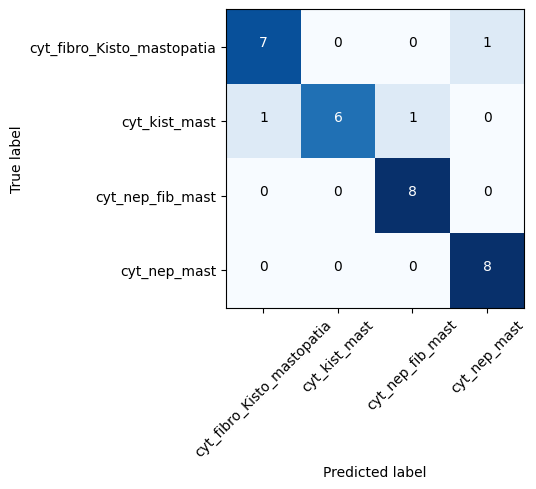

In [722]:
cm_plot_labels = ['cyt_fibro_Kisto_mastopatia', 'cyt_kist_mast', 'cyt_nep_fib_mast', 'cyt_nep_mast']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='')

c:\users\terraform\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


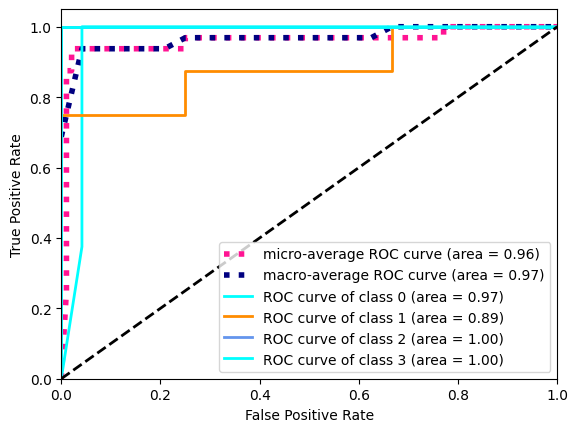

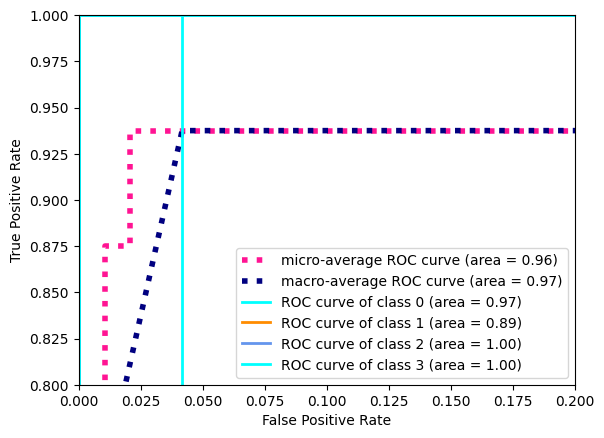

In [723]:
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 4

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()



In [724]:
from sklearn.metrics import classification_report

In [725]:
print(classification_report(y_true=rounded_labels, y_pred=rounded_prediction))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       1.00      0.75      0.86         8
           2       0.89      1.00      0.94         8
           3       0.89      1.00      0.94         8

    accuracy                           0.91        32
   macro avg       0.91      0.91      0.90        32
weighted avg       0.91      0.91      0.90        32



In [726]:
score = metrics.log_loss(test_labels,predictions)
print("Log loss score: {}".format(score))

Log loss score: 1.3387787033518221


ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

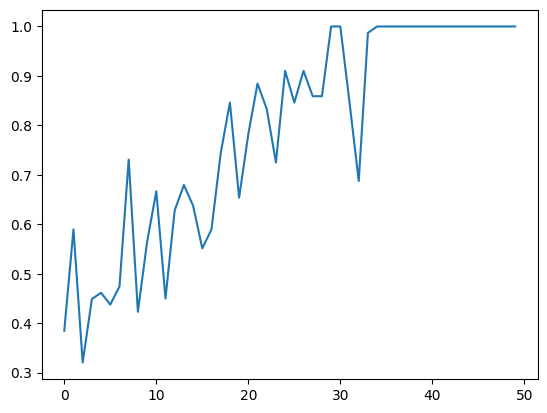

In [727]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(accs)),accs, label = 'Training_accuracy')
plt.plot(range(len(accs)),val_accs, label = 'Validation_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [ ]:
accs = h.history['loss']
val_accs = h.history['val_loss']

plt.plot(range(len(accs)),accs, label = 'Training_loss')
plt.plot(range(len(accs)),val_accs, label = 'Validation_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()